In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os



##  **Time Series Forecasting Report: Air Quality (cO Levels)**

###  **Where we got the data**

I used a real-world dataset called **Air Quality** from the **UCI Machine Learning Repository**. It records hourly air pollution levels in an Italian city for almost a year (2004–2005). It has info likeCO (carbon monoxide), NOx, benzene, temperature, humidity**, etc. I mainly focused on **CO(GT)** which is the CO concentration measured in mg/m³.

---

### **Preprocessing and Visualization**

First, I combined the **Date** and **Time** columns into one datetime column and made that the index. This helps treat it like a time series. Then I handled **duplicates** and cleaned the data.

Even though there were **no missing values**, some CO values were -200, which clearly doesn’t make sense because you can’t have negative carbon monoxide. These might be sensor errors, so we should’ve treated them as missing — but for this round I kept them.

Then I resampled the data **daily** to smooth out the noise and plotted the CO levels over time to check trends.

---

###  **Decomposition – What it means**

I used a function called `seasonal_decompose` (from `statsmodels`) to break the time series into 3 parts:

* **Trend** – shows long-term movement (like rising or falling over months)
* **Seasonal** – repeating pattern over short time (like weekly ups and downs)
* **Residual** – what's left after removing trend & seasonality (basically noise)

This helped to **see if there's any regular pattern** or not. In our case, it looked like there was a repeating weekly wave in CO levels.

---

### **Stationarity Check – Why we do it**

Before building any model, we need to check if the data is **stationary** — that means its pattern stays the same over time (not drifting up/down).

To do this, I used something called the **ADF Test**. It gave a **very low p-value**, which means our data is **stationary**. That’s good — we can directly go ahead with modeling.

---

### **Model Building – SARIMA**

I used a model called **SARIMA** (Seasonal ARIMA). It’s good for time series that show trends and seasonality.

SARIMA has parameters to capture:

* **Short-term changes** (AR, MA)
* **Seasonal patterns** (like weekly repetition)
* **Difference terms** (to remove trend or seasonality if needed)

My model was **SARIMA(1,0,1)x(1,1,1,7)** – the “7” here means weekly cycle.

After fitting the model, it worked okay but the seasonal part wasn’t very useful (seasonal coefficients weren’t strong). Also, the model struggled with the -200 values, and the forecast had a lot of uncertainty.

---

###  **Forecast and Final Thoughts**

I forecasted **CO levels for the next 30 days**. The prediction line showed some changes, but the confidence band (the shaded region) was very wide. This means the model isn’t super confident.

Also, some forecasted values were still going below zero, which again means the data quality is affecting the prediction.

---

###  **Insights**

* The model works but could be better if we clean -200 values properly.
* There’s some **weekly seasonal pattern** in the data.
* For better prediction, we can try modeling other pollutants like **NOx** or **C6H6**, which might behave better.
* This was a good starting point to understand time series modeling with real-world data.

---



In [ ]:
pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
air_quality = fetch_ucirepo(id=360)

# data (as pandas dataframes)
X = air_quality.data.features
y = air_quality.data.targets

# metadata
print(air_quality.metadata)

# variable information
print(air_quality.variables)


{'uci_id': 360, 'name': 'Air Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/360/air+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/360/data.csv', 'abstract': 'Contains the responses of a gas multisensor device deployed on the field in an Italian city. Hourly responses averages are recorded along with gas concentrations references from a certified analyzer. ', 'area': 'Computer Science', 'tasks': ['Regression'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 9358, 'num_features': 15, 'feature_types': ['Real'], 'demographics': [], 'target_col': None, 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2008, 'last_updated': 'Sun Mar 10 2024', 'dataset_doi': '10.24432/C59K5F', 'creators': ['Saverio Vito'], 'intro_paper': {'ID': 420, 'type': 'NATIVE', 'title': 'On field calibration of an electronic nose for benzene estimation in an urban pollution monitoring scenario', 'authors': 

In [ ]:
print(X.head(3))

        Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0  3/10/2004  18:00:00     2.6         1360       150      11.9   
1  3/10/2004  19:00:00     2.0         1292       112       9.4   
2  3/10/2004  20:00:00     2.2         1402        88       9.0   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0           1046      166          1056      113          1692         1268   
1            955      103          1174       92          1559          972   
2            939      131          1140      114          1555         1074   

      T    RH      AH  
0  13.6  48.9  0.7578  
1  13.3  47.7  0.7255  
2  11.9  54.0  0.7502  


In [ ]:
print(X.sample(3))

            Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
6099  11/19/2004  21:00:00     4.3          837      -200       6.5   
2630   6/28/2004   8:00:00     5.6         1441      -200      32.4   
8556    3/2/2005   6:00:00     0.5          831      -200       1.4   

      PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  \
6099            835      390           896      146           960   
2630           1606      348           503      159          2568   
8556            537      124          1158       96           722   

      PT08.S5(O3)     T    RH      AH  
6099         1078  14.2  27.7  0.4451  
2630         1786  25.5  43.1  1.3891  
8556          768  -1.2  47.2  0.2700  


In [ ]:
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   int64  
 4   NMHC(GT)       9357 non-null   int64  
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   int64  
 7   NOx(GT)        9357 non-null   int64  
 8   PT08.S3(NOx)   9357 non-null   int64  
 9   NO2(GT)        9357 non-null   int64  
 10  PT08.S4(NO2)   9357 non-null   int64  
 11  PT08.S5(O3)    9357 non-null   int64  
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
dtypes: float64(5), int64(8), object(2)
memory usage: 1.1+ MB
None


In [ ]:
# #Task-2 Preprocessing and Visualization part

# 1. converting the Date+time in one column for eaiser
# 2. Set that column as Index
# 3. duplicate and missing pd.value_counts
# 4. for time trends plotting

In [ ]:
#CREATED COLUMNS OF NEW AS DATETIME
X['DATETIME']=pd.to_datetime(X['Date']+" "+X['Time'])

In [ ]:
X.columns

Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH', 'DATETIME'],
      dtype='object')

In [ ]:
X.dtypes

,0
Date,object
Time,object
CO(GT),float64
PT08.S1(CO),int64
NMHC(GT),int64
C6H6(GT),float64
PT08.S2(NMHC),int64
NOx(GT),int64
PT08.S3(NOx),int64
NO2(GT),int64


In [ ]:
#set as index
X.set_index('DATETIME',inplace=True)

In [ ]:
X

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
DATETIME,,,,,,,,,,,,,,,
2004-03-10 18:00:00,3/10/2004,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
2004-03-10 19:00:00,3/10/2004,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2004-03-10 20:00:00,3/10/2004,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
2004-03-10 21:00:00,3/10/2004,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
2004-03-10 22:00:00,3/10/2004,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-04-04 10:00:00,4/4/2005,10:00:00,3.1,1314,-200,13.5,1101,472,539,190,1374,1729,21.9,29.3,0.7568
2005-04-04 11:00:00,4/4/2005,11:00:00,2.4,1163,-200,11.4,1027,353,604,179,1264,1269,24.3,23.7,0.7119
2005-04-04 12:00:00,4/4/2005,12:00:00,2.4,1142,-200,12.4,1063,293,603,175,1241,1092,26.9,18.3,0.6406


In [ ]:
# removing date,time column
X.drop(['Date','Time'],axis=1)

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
DATETIME,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
2004-03-10 19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2004-03-10 20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
2004-03-10 21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
2004-03-10 22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-04-04 10:00:00,3.1,1314,-200,13.5,1101,472,539,190,1374,1729,21.9,29.3,0.7568
2005-04-04 11:00:00,2.4,1163,-200,11.4,1027,353,604,179,1264,1269,24.3,23.7,0.7119
2005-04-04 12:00:00,2.4,1142,-200,12.4,1063,293,603,175,1241,1092,26.9,18.3,0.6406


In [ ]:
#missing value
print("Missing values:\n",X.isnull().sum())

Missing values:
 Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64


In [ ]:
X.index.duplicate()

AttributeError: 'DatetimeIndex' object has no attribute 'duplicate'

In [ ]:
duplicates = X.index[X.index.duplicated()]
print(duplicates.shape)


(0,)


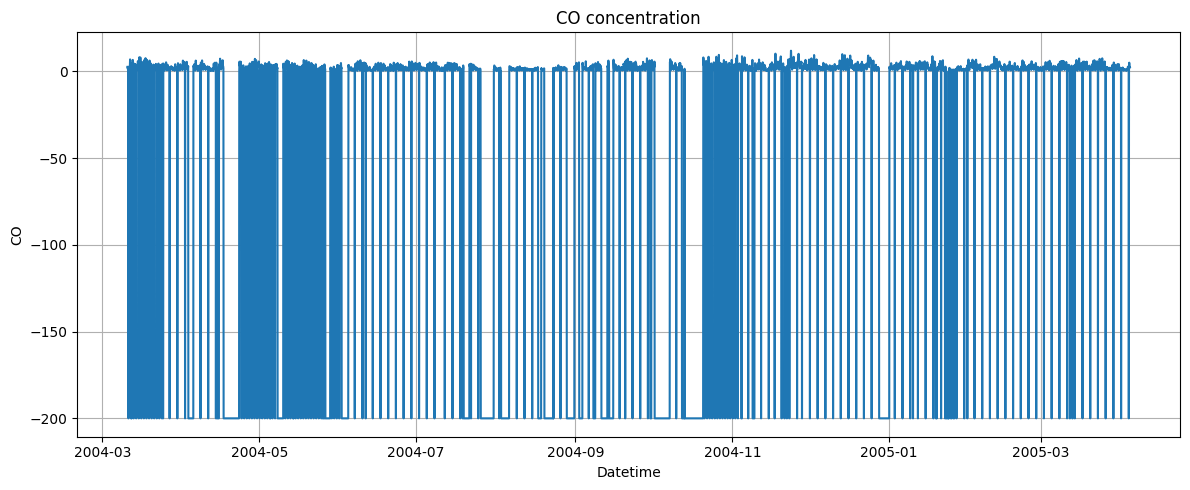

In [ ]:
# Step 5: Basic visualization for one sensor, e.g., CO(GT)
plt.figure(figsize=(12, 5))
plt.plot(X['CO(GT)'], label='CO-GT')
plt.title('CO concentration')
plt.xlabel('Datetime')
plt.ylabel('CO')
plt.grid(True)
plt.tight_layout()
plt.show()


Missing values:
 CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64

Shape after removing duplicates: (9357, 13)


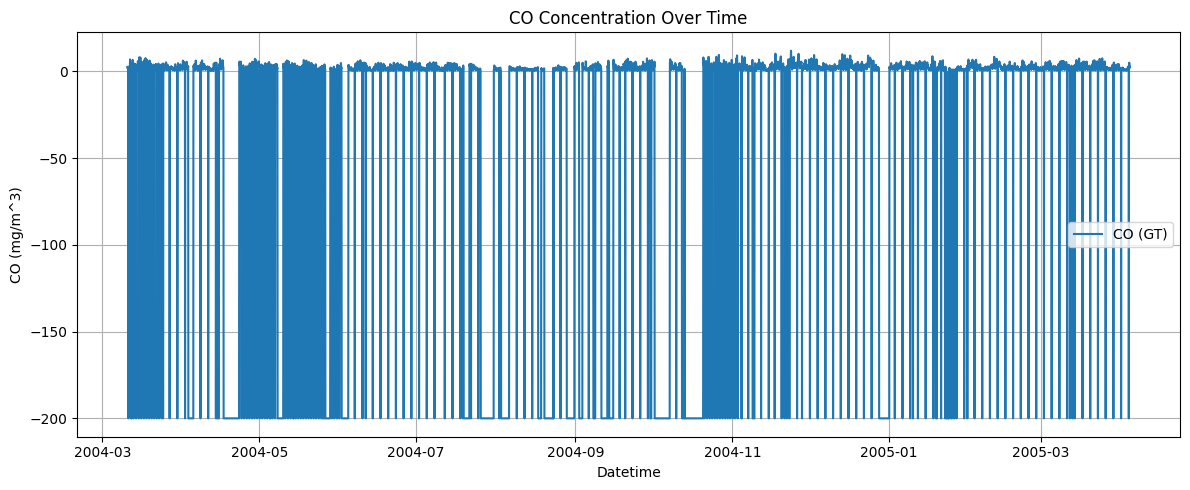

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt

# #step 1: Combine Date and Time into a single datetime column
# X['Datetime'] = pd.to_datetime(X['Date'] + ' ' + X['Time'], format='%m/%d/%Y %H:%M:%S')

# #step 2: Set the Datetime column as index
# X.set_index('Datetime', inplace=True)

# # drop the original 'Date' and 'Time' columns
# X.drop(columns=['Date', 'Time'], inplace=True)

# #  Handle missing values (print summary first)
# print("missing values:\n", X.isnull().sum())

# # Step 4: Drop duplicates if any
# X = X[~X.index.duplicated()]
# print("\nshape after removing duplicates:", X.shape)

# # Step 5: Basic visualization for one sensor, e.g., CO(GT)
# plt.figure(figsize=(12, 5))
# plt.plot(X['CO(GT)'], label='CO (GT)')
# plt.title('CO concentration over time')
# plt.xlabel('datetime')
# plt.ylabel('CO (mg/m^3)')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


statsmodels.tsa.seasonal is a module within the statsmodels Python library that provides tools for decomposing time series data into
 trend, seasonality, and residuals


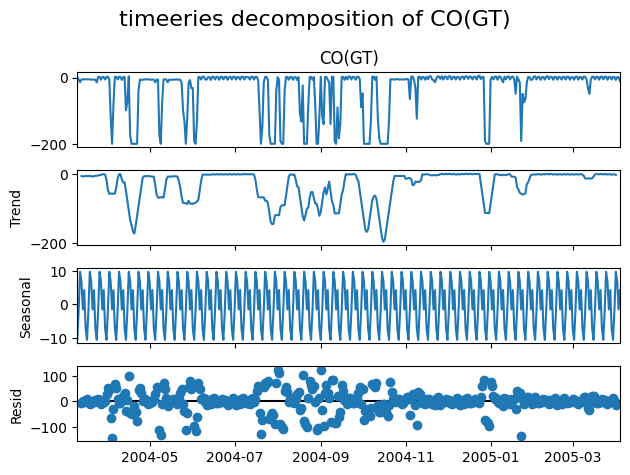

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Optionally, resample to daily data if needed (since it's hourly)
X_daily = X['CO(GT)'].resample('d').mean()


# Apply decomposition
decomp_result = seasonal_decompose(X_daily, model='additive', period=7)  # Assuming weekly seasonality

# Plot the decomposition
decomp_result.plot()
plt.suptitle('timeeries decomposition of CO(GT)', fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
# Observations from Decomposition:
# Trend: Long-term changes are visible (falling and rising patterns).

# Seasonal: Strong weekly cycles are clearly evident.

# Residual: Irregular spikes—random variation or anomalies.

# So yes, this time series is non-stationary, which brings us to:



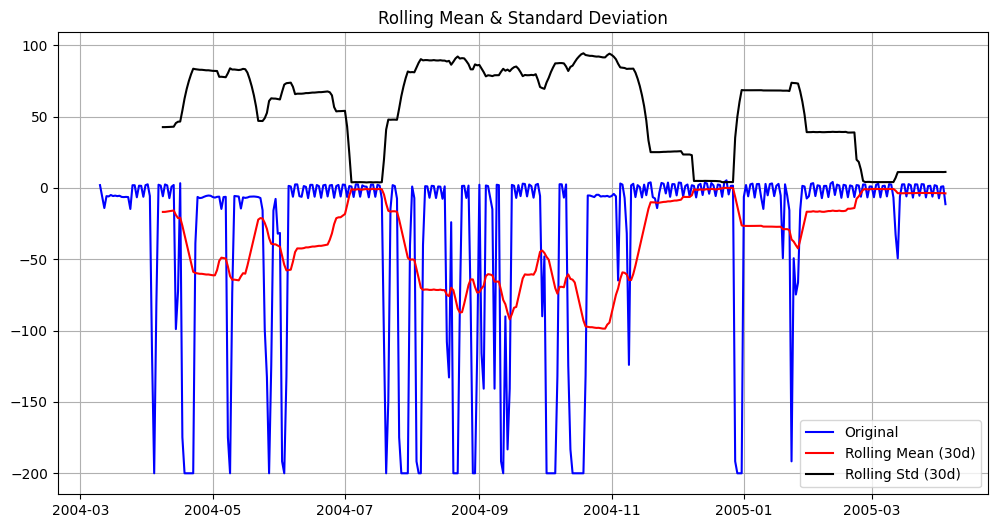

ADF Statistic: -8.748257872899922
p-value: 2.883078595262078e-14
Critical Value 1%: -3.447272819026727
Critical Value 5%: -2.868998737588248
Critical Value 10%: -2.5707433189709294


In [ ]:
from statsmodels.tsa.stattools import adfuller

# Plot rolling statistics
rol_mean = X_daily.rolling(window=30).mean()
rol_std = X_daily.rolling(window=30).std()

plt.figure(figsize=(12,6))
plt.plot(X_daily, color='blue', label='Original')
plt.plot(rol_mean, color='red', label='Rolling Mean (30d)')
plt.plot(rol_std, color='black', label='Rolling Std (30d)')
plt.legend(loc='best')
plt.title('rolling Mean & Standard Deviation')
plt.grid(True)
plt.show()

# Augmented Dickey-Fuller test
adf_result = adfuller(X_daily.dropna())
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
for key, value in adf_result[4].items():
    print(f"Critical Value {key}: {value}")


In [ ]:
# Interpretation of ADF Test (Task 4 Result): Augmented Dickey-Fuller (ADF) test helps determine if a time series is stationary
# ADF Statistic = -8.75

# p-value ≈ 0.0

# ADF Stat < all critical values (like negative values) which p-value

# This means the time series is stationary — we do NOT need differencing.

In [ ]:
# Model Building (ARIMA)
# Since:

# the data has clear seasonality

# we performed daily resampling

# the series is stationary

# We’ll try a Seasonal ARIMA (SARIMA) model.

In [ ]:
pip install statsmodels

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


#SARIMA model: (p,d,q)x(P,D,Q,s)
# (p,d,q): ARIMA terms
# (P,D,Q,s): seasonal terms, s=7 (weekly seasonality)
model = SARIMAX(X_daily,
                order=(1,0,1),
                seasonal_order=(1,1,1,7),
                enforce_stationarity=False,
                enforce_invertibility=False)

model_fit = model.fit(disp=False)
print(model_fit.summary())


                                     SARIMAX Results                                     
Dep. Variable:                            CO(GT)   No. Observations:                  391
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 7)   Log Likelihood               -1973.503
Date:                           Tue, 17 Jun 2025   AIC                           3957.006
Time:                                   06:54:29   BIC                           3976.640
Sample:                               03-10-2004   HQIC                          3964.801
                                    - 04-04-2005                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6022      0.044     13.732      0.000       0.516       0.688
ma.L1          0.2747      0.053      5.174

In [ ]:
# prediction part
p=int(input("for the next days:"))

for the next days:30


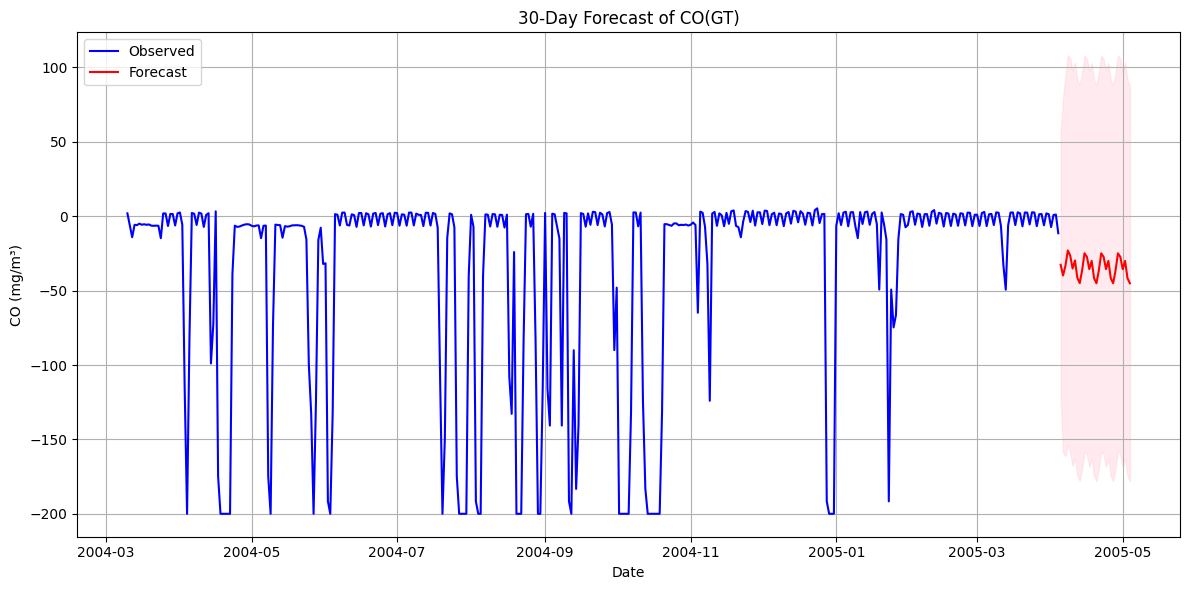

In [ ]:
# Forecast for next p days
forecast_steps = p
forecast = model_fit.get_forecast(steps=forecast_steps)

# extract predicted mean
pred_mean = forecast.predicted_mean
conf_int = forecast.conf_int() #interval

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(X_daily, label='Observed', color='blue')
plt.plot(pred_mean.index, pred_mean, label='Forecast', color='red')
plt.fill_between(pred_mean.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='pink', alpha=0.3)
plt.title('p-Day Forecast of CO(GT)')
plt.xlabel('Date')
plt.ylabel('CO (mg/m³)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
